In [2]:
%pylab inline
import pickle as pk

Populating the interactive namespace from numpy and matplotlib


In [3]:
#labels is the labels or the neighbors of a test point
#It consists of a list of 1000 arrays each corresponding to one test examples
# each array contains 60000 elements which are the labels of the 60000 trainining examples sorted by increasing 
# distance to the test example.

# with open('labels.pkl','br') as pklfile:
#     labels=pk.load(pklfile)
# len(labels), labels[0].shape

In [4]:
!ls -lrth *.npz

-rw-r--r--  1 yoavfreund  staff   1.1G Apr 26 22:01 IndexByDistance.npz


In [5]:
X=np.load('IndexByDistance.npz')
indicesByDistance=X['a']

In [6]:
import mnist

def recast(x):
    return np.array(x,dtype=np.float32)
train_images = recast(mnist.train_images())
train_labels = mnist.train_labels()
test_images = recast(mnist.test_images())
test_labels = mnist.test_labels()

In [7]:
_range=1000

def find_sig(S,thr=5):
    """ S is a matrix of 10 X _range.
    entry S[i,j] is the significance associated with label i when considering j nearset neighbors.
    Find the first entry of x that is larger than thr.
    returns predicted_label,stopping_time
    """
    f=[]
    stopping_time=_range
    for i in range(10):
        f=np.nonzero(S[i,:]>thr)[0]
        if f.shape[0]>0:
            f=f[0]
            if stopping_time > f:
                stopping_time=f
                predicted_label=i
    if stopping_time<_range:
        return predicted_label,stopping_time
    # did not find anything with significance > thr, then take the one with highest significance
    _argmax=np.argmax(S,axis=1)
    _max = np.max(S,axis=1)
    predicted_label = np.argmax(_max)
    stopping_time = _argmax[predicted_label]
    #print(stopping_time)
    return predicted_label,stopping_time
            
    

In [8]:
from collections import Counter
def find_label_knn(test_index,k=5):
    L=labels[test_index]
    C=list(Counter(L[:k]).items())
    S=sorted(C,key=lambda x:x[1],reverse=True)
    return np.array(S).transpose()

In [9]:
def find_label_adaptive(test_index,thr=4):
    """Find label of test example test_index using adaptive k NN"""
    C=[]
    sig=[]
    P=np.zeros([10,_range])
    L=labels[test_index]
    scale=arange(1,_range+1,1)
    for i in range(10):
        C.append(np.cumsum(L==i))
        P[i,:]=(C[-1][:_range]-(scale/10))/sqrt(scale)
    predicted_label,stopping_time = find_sig(P,thr=thr)
    sigs_at_stop = P[:,stopping_time]
    I=argsort(sigs_at_stop)
    Sigs=sigs_at_stop[I]
    prediction=np.array([I[Sigs>0],Sigs[Sigs>0]],dtype=np.int16)
    return prediction[:,-1::-1]

In [10]:
def compute_errs(method="adaptive",**kwargs):
    errs=np.zeros([4,11])
    n=test_labels.shape[0]
    for i in range(n):
        if method=='adaptive':
            pred_label=find_label_adaptive(i,**kwargs)
        else:
            pred_label=find_label_knn(i,**kwargs)

        prediction=int(pred_label[0,0])
        err = 0 #prediction error
        labelSet=set(pred_label[0,:])
        if prediction != test_labels[i]:
            err=1 # incorrect prediction
        if test_labels[i] in labelSet:
            err+=2 # prediction in prediction set
        multi=pred_label.shape[1]
        if prediction==-1:
            multi=0
            err=1
        errs[err,multi]+=1
        if i%100==0:
            print('\r',i,end='')
    errs=np.array(errs,dtype=np.int16)
    print()       

    cr_sums=np.sum(errs,axis=1)
    print('size of set total',''.join(["%5d"%x for x in range(11)]))
    print('total      %6d'%np.sum(cr_sums),''.join(["%5d"%x for x in np.sum(errs,axis=0)]))
    print('incorrect  %6d'%np.sum(cr_sums[[0,1,3]]),''.join(["%5d"%x for x in np.sum(errs,axis=0)-errs[2,:]]))
    #print('in set     ',''.join(["%6d"%x for x in errs[2,:]+errs[3,:]]))
    print('not in set %6d'%np.sum(cr_sums[[0,1]]),''.join(["%5d"%x for x in errs[0,:]+errs[1,:]]))
    return cr_sums

In [11]:
knn_err=[]

In [25]:
#for p in arange(0,1,0.1):
p=0.3
print(50*'=','p=',p)

random=np.random.choice(10,train_labels.shape)

combined=np.dstack((train_labels,random))
flip_p = (train_labels%4==0)*0.9
flip_p[:10],train_labels[:10]

================================================== p= 0.3


(array([0. , 0.9, 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0.9]),
 array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8))

In [26]:
selector=np.random.binomial(1,flip_p,random.shape)
sel=np.dstack([1-selector,selector])

noisy_labels=sum(combined*sel,axis=2).squeeze()
noisy_labels.shape

labels=noisy_labels[indicesByDistance]
labels[:3,:10]

array([[7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [27]:
for i in range(12):
    k=2**i
    print('='*40,'knn with k=',k,end=', ')
    cr_sums=compute_errs('knn',k=k)
    #print(cr_sums)
    knn_err.append({'method':'knn','p':p,'k':k,'err':np.sum(cr_sums[[0,1,3]])/100.})

for theta in range(1,4):
    print('='*40,'adaptive NN with theta=',theta)
    cr_sums=compute_errs('adaptive',thr=theta)
    knn_err.append({'method':'adaptive','p':p,'theta':theta,'err':np.sum(cr_sums[[0,1,3]])/100.})

#knn_err

 9900=================================== knn with k= 1, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     010000    0    0    0    0    0    0    0    0    0
incorrect    2574     0 2574    0    0    0    0    0    0    0    0    0
not in set   2574     0 2574    0    0    0    0    0    0    0    0    0
 9900=================================== knn with k= 2, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0 7156 2844    0    0    0    0    0    0    0    0
incorrect    2574     0  302 2272    0    0    0    0    0    0    0    0
not in set   2010     0  302 1708    0    0    0    0    0    0    0    0
 9900=================================== knn with k= 4, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0 6622  613 1363 1402    0    0    0    0    0    0
incorrect    2437     0   57  245  955 1180    0    0    0    0    0    0
not in set   13

In [14]:
import pickle as pk

pk.dump(knn_err,open('knn_err.pkl','bw'))

knn_err2=pk.load(open('knn_err.pkl','br'))


In [27]:
adaptive = np.zeros(10)
for row in knn_err:
    if row['method']=='adaptive' and row['theta']==2:
        i=int(10*row['p'])
        err=row['err']
        adaptive[i] = err
adaptive

array([ 3.39,  3.71,  3.84,  4.15,  4.73,  5.36,  6.26,  7.53,  9.61,
       11.9 ])

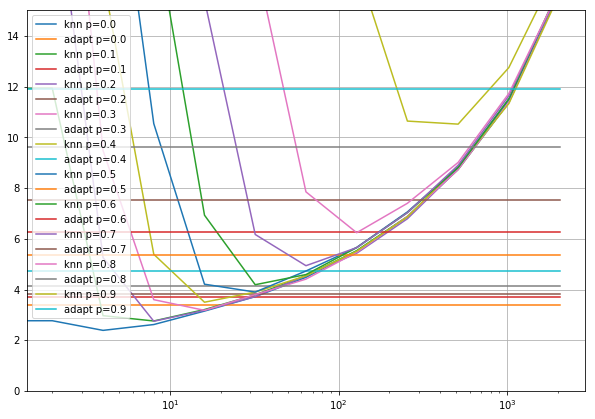

In [52]:
err=np.zeros(12)
K=np.zeros(12)
knn_best=[]
figure(figsize=[10,7])
for j in range(10):
    p=j/10.
    A=adaptive[j]; A=[A]*12
    _min=100
    for row in knn_err:
        if abs(row['p']-p)<0.001 and row['method']=='knn':
            i=int(log2(row['k']+1))
            err[i] = row['err']
            if row['err']< _min:
                _min=row['err']
                _min_i=row['k']
            K[i]=2**i
    semilogx(K,err,label='knn p=%2.1f'%p);
    semilogx(K,A,label='adapt p=%2.1f'%p);
    knn_best.append((j/10.,_min_i,_min))
    
ylim([0,15])
legend()
grid()

In [49]:
for i in range(10):
    L=knn_best[i]
    print(" %3.1f\t %4d \t %5.2f \t %5.2f"%(L[0],L[1],L[2],adaptive[i]))

 0.0	    4 	  2.39 	  3.39
 0.1	    8 	  2.76 	  3.71
 0.2	    8 	  2.75 	  3.84
 0.3	   16 	  3.18 	  4.15
 0.4	   16 	  3.50 	  4.73
 0.5	   32 	  3.90 	  5.36
 0.6	   32 	  4.19 	  6.26
 0.7	   64 	  4.94 	  7.53
 0.8	  128 	  6.24 	  9.61
 0.9	  512 	 10.52 	 11.90


## Old stuff

IndexError: too many indices for array

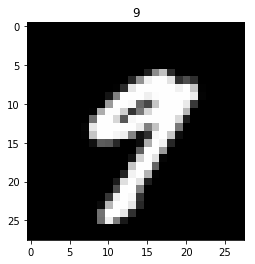

<Figure size 720x576 with 0 Axes>

In [47]:
i=8520 # a 4 that looks like a 9
i=20
#i=23
#i=320

threshold=5
L=labels[i]
true_label=test_labels[i]
imshow(test_images[i,:,:],cmap='gray')
title(str(true_label))

figure(figsize=[10,8])
_range=1000
C=[]
sig=[]
scale=arange(1,_range+1,1)
for i in range(10):
    C.append(np.cumsum(L==i))
    P=(C[-1][:_range]-(scale/10))/sqrt(scale)
    sig.append(find_sig(P))
    _name=str(i)
    if i==true_label:
        _name+= ' true label '
    plot(P,label=_name)
legend()
grid()
print(sig)

In [ ]:
P[:10]

In [ ]:
np.nonzero(P>1)[0].shape

In [ ]:
# instead of giving up when reaching _range, use the label that showed the largest "p".